In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as skn

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


import warnings
warnings.filterwarnings('ignore')

In [46]:
rs = 42

df = pd.read_csv('NY-House-Dataset.csv')
df.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [47]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [48]:
sel_cols = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']
df = df[sel_cols]
df.head()


,TYPE,BEDS,BATH,PROPERTYSQFT,PRICE
0,Condo for sale,2,2.000000,1400.0,315000
1,Condo for sale,7,10.000000,17545.0,195000000
2,House for sale,4,2.000000,2015.0,260000
3,Condo for sale,3,1.000000,445.0,69000
4,Townhouse for sale,7,2.373861,14175.0,55000000


In [49]:
df.TYPE.unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

In [50]:
df['TYPE'] = df['TYPE'].str.replace(' for sale' , '')
df.loc[df['TYPE'] == 'Condop' , 'TYPE'] = 'Condo'
df.TYPE.value_counts()

TYPE
Co-op                1450
House                1012
Condo                 896
Multi-family home     727
Townhouse             299
Pending               243
Contingent             88
Land                   49
For sale               20
Foreclosure            14
Coming Soon             2
Mobile house            1
Name: count, dtype: int64

In [51]:
keep_types = ['Co-op' , 'House' , 'Condo' , 'Multi-family home']
df = df[df.TYPE.isin(keep_types)]

df.describe()

,BEDS,BATH,PROPERTYSQFT,PRICE
count,4085.000000,4085.000000,4085.000000,4.085000e+03
mean,3.248960,2.276971,2074.977684,2.177395e+06
std,2.665199,1.942809,2381.823726,3.389010e+07
min,1.000000,1.000000,250.000000,4.950000e+04
25%,2.000000,1.000000,1135.000000,4.740000e+05
50%,3.000000,2.000000,2184.207862,7.990000e+05
75%,4.000000,3.000000,2184.207862,1.385000e+06
max,50.000000,50.000000,65535.000000,2.147484e+09


In [52]:
lower_iqr = np.nanpercentile(df.PRICE , 25)
upper_iqr = np.nanpercentile(df.PRICE , 75)

iqr = upper_iqr - lower_iqr

lower_bound = lower_iqr - (1.5 * iqr)
upper_bound = upper_iqr + (1.5 * iqr)


df = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_iqr)]

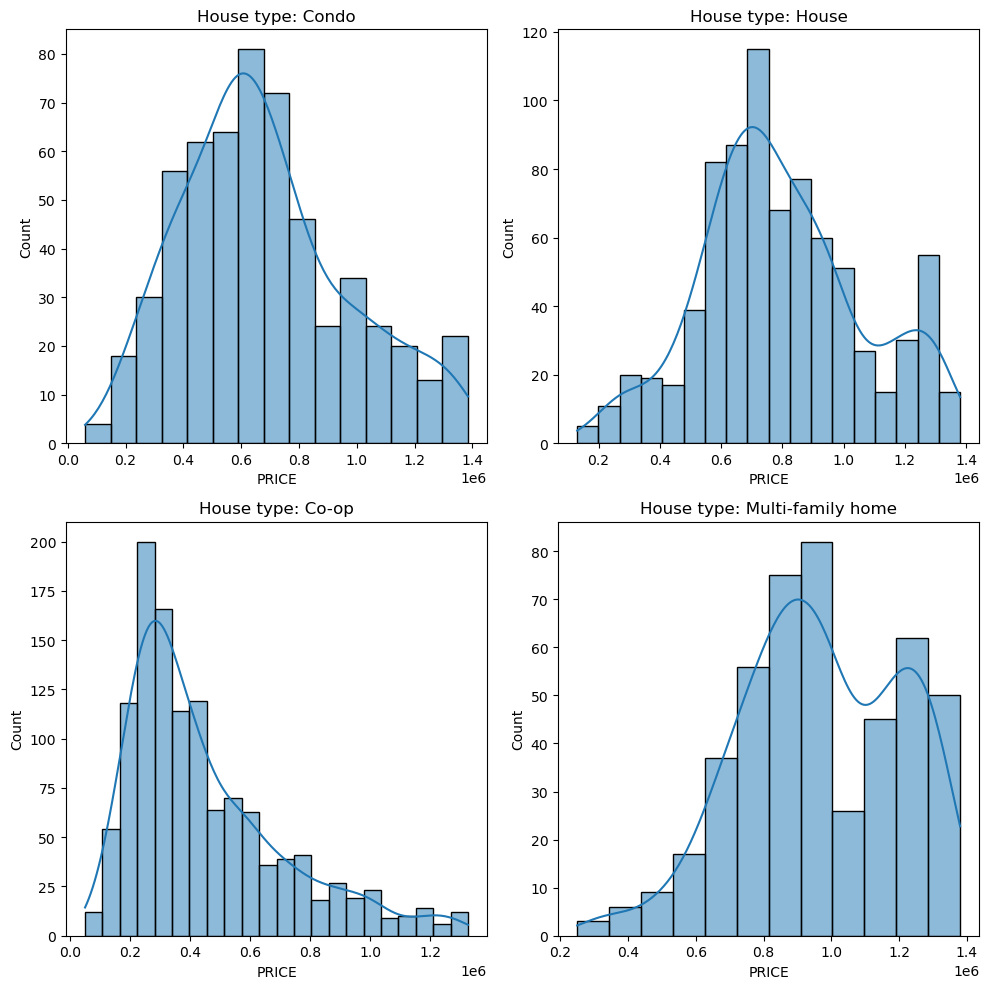

In [53]:
import seaborn as sns


house_types = df.TYPE.unique()

fig , axs = plt.subplots(2,2 , figsize = (10,10))

axs = axs.flatten()

for i in range(len(house_types)):
    sns.histplot(
        data=df[df["TYPE"] == house_types[i]],
        x="PRICE",
        kde=True,
        ax=axs[i]
    )
    axs[i].set_title(f"House type: {house_types[i]}")

plt.tight_layout()
plt.show()

In [54]:
fig = px.scatter(data_frame=df, x = 'PROPERTYSQFT', y = 'PRICE' , facet_col= 'TYPE' , trendline= 'lowess' , trendline_scope='overall')
fig.show()

In [55]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()


In [56]:

from scipy.stats import ttest_ind
import itertools

house_types = df["TYPE"].unique()

res = []

# Compare all pairs of house types
for a, b in itertools.combinations(house_types, 2):
    prices_a = df[df["TYPE"] == a]["PRICE"]
    prices_b = df[df["TYPE"] == b]["PRICE"]
    t_stat, p_val = ttest_ind(prices_a, prices_b, equal_var=False)  # Welch’s t-test
    temp = {
        "comparison": f"{a} vs {b}",
        "t-stat": t_stat,
        "p-value": p_val
    }
    res.append(temp)

res = pd.DataFrame(res)

res

,comparison,t-stat,p-value
0,Condo vs House,-7.450237,1.820583e-13
1,Condo vs Co-op,16.052906,7.809951e-52
2,Condo vs Multi-family home,-17.671897,2.743682e-61
3,House vs Co-op,28.647038,2.739341e-147
4,House vs Multi-family home,-12.115635,9.545670e-32
5,Co-op vs Multi-family home,-39.121160,1.961760e-198


In [57]:
df.loc[df['TYPE'].isin(['House' , 'Condo']) , 'TYPE'] = 'Condo & House'


In [58]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()

In [59]:
bath_price = df.groupby('BATH')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bath_price['PRICE'].values.reshape(-1, 1)

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=rs).fit(X)
bath_price['BATH_GROUP'] = kmeans.labels_

# Map back
bath_group_map = dict(zip(bath_price['BATH'], bath_price['BATH_GROUP']))
df['BATH_GROUP'] = df['BATH'].map(bath_group_map)



fig = px.box(data_frame=df, x = 'BATH_GROUP', y = 'PRICE' , color= 'BATH_GROUP' )
fig.show()

In [60]:
bath_groups = sorted(df['BATH_GROUP'].unique())

for group in bath_groups:
    print(f"Group {group}:")
    print(f"Unique bath values: {df[df['BATH_GROUP'] == group]['BATH'].unique().astype(str)}")

Group 0:
Unique bath values: ['2.0' '3.0' '2.3738608579684373']
Group 1:
Unique bath values: ['6.0' '8.0' '4.0' '5.0' '9.0' '7.0']
Group 2:
Unique bath values: ['1.0']


In [61]:
# Get average price per bath type
bed_price = df.groupby('BEDS')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bed_price['PRICE'].values.reshape(-1, 1)

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=rs).fit(X)
bed_price['BEDS_GROUP'] = kmeans.labels_

# Map back
bed_group_map = dict(zip(bath_price['BATH'], bed_price['BEDS_GROUP']))
df['BEDS_GROUP'] = df['BEDS'].map(bed_group_map)



fig = px.box(data_frame=df, x = 'BEDS_GROUP', y = 'PRICE' , color= 'BEDS_GROUP' )
fig.show()

In [ ]:
bath_groups = sorted(df['BEDS_GROUP'].unique())

for group in bath_groups:
    print(f"Group {group}:")
    print(f"Unique bed values: {df[df['BEDS_GROUP'] == group]['BEDS'].unique().astype(str)}")

Group 0.0:
Unique bed values: ['4' '3' '5' '6' '7' '9' '8']
Group 1.0:
Unique bed values: ['2']
Group 2.0:
Unique bed values: ['1']
Group nan:
Unique bed values: []


In [63]:
categorical_cols = ['BEDS_GROUP' , 'BATH_GROUP' , 'TYPE']

X = df.drop(columns = ['PRICE' ])
y = np.log(df['PRICE'])

for col in categorical_cols:
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.25 , random_state = 42)

x_scaler = MinMaxScaler()
X_train['PROPERTYSQFT'] = x_scaler.fit_transform(X_train['PROPERTYSQFT'].values.reshape(-1, 1))
X_test['PROPERTYSQFT'] = x_scaler.transform(X_test['PROPERTYSQFT'].values.reshape(-1, 1))

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)) 
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2298, 6)
y_train shape: (2298, 1)
X_test shape: (767, 6)
y_test shape: (767, 1)


In [73]:
def train_and_evaluate_model(model, scaler , X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_test)
    
    
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    ret = {
        'model_name' : type(model).__name__ , 
        'rmse' : rmse,
        'mape' : mape ,
        'y_pred' : y_pred
    }
    
    
    return ret

In [78]:
models = [
         LinearRegression(),
         DecisionTreeRegressor(criterion= 'squared_error' , max_depth = 5),
         RandomForestRegressor(criterion= 'squared_error' , max_depth = 5),
         KNeighborsRegressor(n_neighbors=5 , weights='distance' , algorithm='auto')
         ]



results = [train_and_evaluate_model(model, y_scaler, X_train, y_train, X_test, y_test) for model in models]


y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

fig = make_subplots(rows=2, cols=2  , subplot_titles=[f"{result['model_name']} RMSE = {result['rmse']:.2f} MAPE = {result['mape']:.2f}" for result in results])

row_idx = 1
col_idx = 1

for _ , result in enumerate(results):
    
    if row_idx > 2:
        row_idx = 1
        col_idx += 1
    
    y_pred = result['y_pred']

    fig.add_trace(go.Scatter(x=np.exp(y_test.ravel()), y=np.exp(y_pred.ravel()), mode='markers' , name = result['model_name']),
              row=row_idx, col=col_idx)
    
    row_idx += 1


fig.update_layout(
    height=1200,  
    width=1300,  
    title_text="Predicted vs acutal prices on test set"
)


fig.show()

